# Prepare HTML pages for use with RAG

In [4]:
%pip install -qU langchain tqdm transformers
%pip install -qU requests

Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kobe 2.0 requires sacrebleu>=2.0.0, but you have sacrebleu 1.5.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [15]:
import requests
import os

def download_urls(urls, saved_dir):
    for url in urls:
        response = requests.get(url)
        out_file = os.path.join(saved_dir, '_'.join(url.split('/')[3:-1]) + '.html')
        print(f'{url}->{out_file}')
        with open(out_file, 'wb') as f:
            f.write(response.content)

# Example usage
url_list = ['https://www.va.gov/disability/after-you-file-claim/',
            'https://www.va.gov/change-address/',
            'https://www.va.gov/change-direct-deposit/',
            'https://www.va.gov/claim-or-appeal-status/',
            'https://www.va.gov/decision-reviews/',
            'https://www.va.gov/disability/dependency-indemnity-compensation/',
            'https://www.va.gov/disability/eligibility/hazardous-materials-exposure/',
            'https://www.va.gov/disability/eligibility/illnesses-within-one-year-of-discharge/',
            'https://www.va.gov/disability/eligibility/ptsd/',
            'https://www.va.gov/disability/eligibility/special-claims/',
            'https://www.va.gov/disability/eligibility/',
            'https://www.va.gov/disability/file-disability-claim-form-21-526ez/',
            'https://www.va.gov/disability/how-to-file-claim/additional-forms/',
            'https://www.va.gov/disability/how-to-file-claim/evidence-needed/fully-developed-claims/',
            'https://www.va.gov/disability/how-to-file-claim/when-to-file/',
            'https://www.va.gov/disability/how-to-file-claim/evidence-needed/',
            'https://www.va.gov/disability/how-to-file-claim/',
            'https://www.va.gov/disability/upload-supporting-evidence/',
            'https://www.va.gov/va-payment-history/',
            'https://www.va.gov/disability/view-disability-rating/',
            'https://www.va.gov/disability/how-to-file-claim/additional-forms/'
            ]


In [16]:
# download_urls(url_list, 'input/va')

https://www.va.gov/disability/after-you-file-claim/->input/va/disability_after-you-file-claim.html
https://www.va.gov/change-address/->input/va/change-address.html
https://www.va.gov/change-direct-deposit/->input/va/change-direct-deposit.html
https://www.va.gov/claim-or-appeal-status/->input/va/claim-or-appeal-status.html
https://www.va.gov/decision-reviews/->input/va/decision-reviews.html
https://www.va.gov/disability/dependency-indemnity-compensation/->input/va/disability_dependency-indemnity-compensation.html
https://www.va.gov/disability/eligibility/hazardous-materials-exposure/->input/va/disability_eligibility_hazardous-materials-exposure.html
https://www.va.gov/disability/eligibility/illnesses-within-one-year-of-discharge/->input/va/disability_eligibility_illnesses-within-one-year-of-discharge.html
https://www.va.gov/disability/eligibility/ptsd/->input/va/disability_eligibility_ptsd.html
https://www.va.gov/disability/eligibility/special-claims/->input/va/disability_eligibility_sp

In [17]:
from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders import BSHTMLLoader

loader = DirectoryLoader('input/va', glob="*.html", loader_cls=BSHTMLLoader)
docs = loader.load()
len(docs)

20

In [27]:
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')

# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

In [28]:
token_counts = [tiktoken_len(doc.page_content) for doc in docs]
print(f"""Min: {min(token_counts)}
Avg: {int(sum(token_counts) / len(token_counts))}
Max: {max(token_counts)}""")

Min: 200
Avg: 1267
Max: 3185


In [30]:
%pip install seaborn

  Using cached seaborn-0.13.0-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


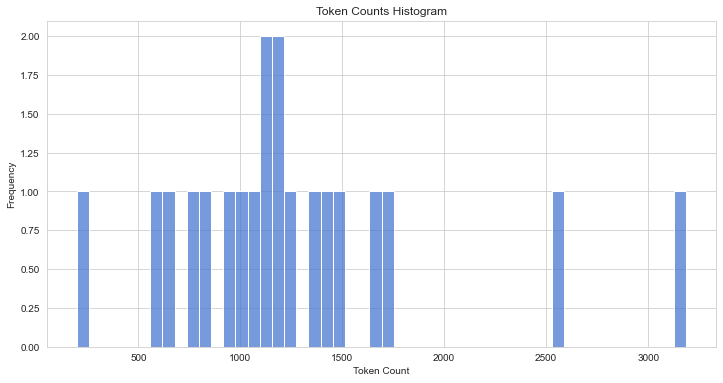

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# set style and color palette for the plot
sns.set_style("whitegrid")
sns.set_palette("muted")

# create histogram
plt.figure(figsize=(12, 6))
sns.histplot(token_counts, kde=False, bins=50)

# customize the plot info
plt.title("Token Counts Histogram")
plt.xlabel("Token Count")
plt.ylabel("Frequency")

plt.show()

In [32]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=20,  # number of tokens overlap between chunks
    length_function=tiktoken_len,
    separators=['\n\n', '\n', ' ', '']
)

In [36]:
docs[0].metadata

{'source': 'input/va/claim-or-appeal-status.html', 'title': 'Check Your VA Claim, Decision Review, Or Appeal Status | Veterans Affairs'}

In [37]:
from tqdm.auto import tqdm
import hashlib

md5 = hashlib.md5()
documents = []

for doc in tqdm(docs):
    url = doc.metadata['source']
    md5.update(url.encode('utf-8'))
    uid = md5.hexdigest()[:12]
    chunks = text_splitter.split_text(doc.page_content)
    for i, chunk in enumerate(chunks):
        documents.append({
            'id': f'{uid}-{i}',
            'text': chunk,
            'source': url
        })

len(documents)


/Users/lei.a.chen/opt/anaconda3/envs/p39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 20/20 [00:00<00:00, 128.04it/s]


93

In [ ]:
import json

with open('input/train.jsonl', 'w') as f:
    for doc in documents:
        f.write(json.dumps(doc) + '\n')